<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-and-combine-datasets" data-toc-modified-id="Read-and-combine-datasets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read and combine datasets</a></span></li><li><span><a href="#Read-ECCO-data" data-toc-modified-id="Read-ECCO-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read ECCO data</a></span></li><li><span><a href="#Read-Argo-climatology" data-toc-modified-id="Read-Argo-climatology-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read Argo climatology</a></span></li><li><span><a href="#Compare-ECCO-and-Argo-gradients?" data-toc-modified-id="Compare-ECCO-and-Argo-gradients?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compare ECCO and Argo gradients?</a></span><ul class="toc-item"><li><span><a href="#Histograms" data-toc-modified-id="Histograms-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Histograms</a></span></li><li><span><a href="#smooth-argo" data-toc-modified-id="smooth-argo-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>smooth argo</a></span></li></ul></li><li><span><a href="#Idealized-gradient-test" data-toc-modified-id="Idealized-gradient-test-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Idealized gradient test</a></span></li></ul></div>

# Read and combine datasets

In [240]:
import sys
sys.path.append('../eddydiff/')

import eddydiff as ed

In [241]:
def plot_gradients(input, region):
        
    isokwargs = dict(yincrease=False, cmap=mpl.cm.RdYlBu_r, center=0, robust=True)
    ρkwargs = dict(yincrease=False, levels=50, colors='w')
    TSkwargs = dict(yincrease=False, levels=40, colors='k')

    f, ax = plt.subplots(2, 2, sharex=True, sharey=True)

    f.set_size_inches(12, 8)

    (input.dTiso.sel(**region)
     .plot(ax=ax[0,0], **isokwargs))
    (input.Tmean.sel(**region)
     .plot.contour(ax=ax[0,0], **TSkwargs))
    (input.ρmean.sel(**region)
     .plot.contour(ax=ax[0,0], **ρkwargs))

    (input.dSiso.sel(**region)
     .plot(ax=ax[1,0], **isokwargs))
    (input.Smean.sel(**region)
     .plot.contour(ax=ax[1,0], **TSkwargs))
    (input.ρmean.sel(**region)
     .plot.contour(ax=ax[1,0], **ρkwargs))

    (input.dTdia.sel(**region)
     .plot(ax=ax[0,1], **isokwargs))
    (input.Tmean.sel(**region)
     .plot.contour(ax=ax[0,1], **TSkwargs))
    (input.ρmean.sel(**region)
     .plot.contour(ax=ax[0,1], **ρkwargs))

    (input.dSdia.sel(**region)
     .plot(ax=ax[1,1], **isokwargs))
    (input.Smean.sel(**region)
     .plot.contour(ax=ax[1,1], **TSkwargs))
    (input.ρmean.sel(**region)
     .plot.contour(ax=ax[1,1], **ρkwargs))
    
    [aa.set_xlabel('') for aa in ax[0,:]]
    plt.tight_layout()
    
    plt.suptitle(input.attrs['dataset'], y=1.01)

    return ax

# Read ECCO data

In [242]:
ρfile = '../datasets/ecco/interp_climatology/RHOAnoma.0001.nc'
Sfile = '../datasets/ecco/interp_climatology/SALT.0001.nc'
Tfile = '../datasets/ecco/interp_climatology/THETA.0001.nc'

T = xr.open_dataset(Tfile, autoclose=True,
                    decode_times=False).pipe(format_ecco)
S = xr.open_dataset(Sfile, autoclose=True,
                    decode_times=False).pipe(format_ecco)
ρ = xr.open_dataset(ρfile, autoclose=True,
                    decode_times=False).pipe(format_ecco)

ecc = xr.merge([T, S, ρ]).rename({'THETA': 'Tmean', 'SALT': 'Smean'})

# roll so that pacific is in the middle and we have coverage of all 3 basins
ecc = ecc.roll(lon=-400)
ecc.lon.values[ecc.lon.values < 20] += 360

annual = ecc.mean(dim='time')
annual['ρmean'] = annual.RHOAnoma + 1029

ed.estimate_clim_gradients(annual)

annual.attrs['name'] = "Mean fields and isopycnal, diapycnal gradients from ECCO v4r3"
annual.attrs['dataset'] = 'ecco'
annual.to_netcdf('../datasets/ecco_annual_iso_gradient.nc')

annual

ValueError: dimensions ('lat', 'lon', 'pres') must have the same length as the number of data dimensions, ndim=0

In [238]:
ed.estimate_clim_gradients(annual)

NameError: name 'ed' is not defined

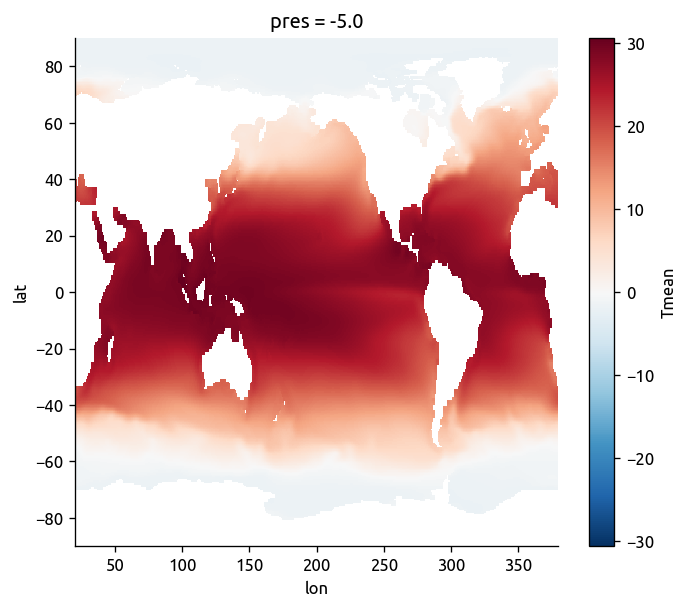

In [4]:
annual.Tmean.sel(pres=0, method='nearest').plot()

# Read Argo climatology

In [38]:
argoT = xr.open_dataset('../datasets/argoclim/RG_ArgoClim_Temperature_2016.nc',
                        autoclose=True, decode_times=False)
argoS = xr.open_dataset('../datasets/argoclim/RG_ArgoClim_Salinity_2016.nc',
                        autoclose=True, decode_times=False)

argo = xr.merge([argoT, argoS])

argo = argo.rename({'ARGO_TEMPERATURE_MEAN': 'Tmean',
                    'ARGO_TEMPERATURE_ANOMALY': 'Tanom',
                    'ARGO_SALINITY_MEAN': 'Smean',
                    'ARGO_SALINITY_ANOMALY': 'Sanom',
                    'LATITUDE': 'lat',
                    'LONGITUDE': 'lon',
                    'PRESSURE': 'pres',
                    'TIME': 'time'}).drop(['BATHYMETRY_MASK', 'Tanom', 'Sanom', 'time'])

_, pmat = xr.broadcast(argo.Tmean, argo.pres)

argo['ρmean'] = xr.DataArray(sw.pden(argo.Smean, argo.Tmean, pmat, 0),
                             dims=argo.Smean.dims, coords=argo.Smean.coords)

del pmat

# apply an averaging operator?
estimate_clim_gradients(argo)

argo.attrs['name'] = 'Mean fields, anomalies and isopycnal, diapycnal gradients from Argo climatology'
argo.attrs['dataset'] = 'argo'
argo.to_netcdf('../datasets/argo_clim_iso_gradients.nc')

argo

/home/deepak/work/python/xarray/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/deepak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/deepak/work/python/xarray/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)


<xarray.Dataset>
Dimensions:  (lat: 130, lon: 360, pres: 58)
Coordinates:
  * lon      (lon) float32 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5 28.5 29.5 ...
  * lat      (lat) float32 -64.5 -63.5 -62.5 -61.5 -60.5 -59.5 -58.5 -57.5 ...
  * pres     (pres) float32 2.5 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0 90.0 ...
Data variables:
    Tmean    (pres, lat, lon) float32 -1.162 -1.163 -1.163 -1.159 -1.155 ...
    Smean    (pres, lat, lon) float32 34.047 34.036 34.028 34.019 34.013 ...
    ρmean    (pres, lat, lon) float32 1027.3867 1027.3779 1027.3715 1027.364 ...
    dTiso    (pres, lat, lon) float32 7.3083123e-07 6.177247e-07 ...
    dTdia    (pres, lat, lon) float32 -0.00080000545 -0.00080000557 ...
    dSiso    (pres, lat, lon) float32 1.3803117e-07 0.0 0.0 1.3803106e-07 ...
    dSdia    (pres, lat, lon) float32 1.3803117e-07 0.0 0.0 1.3803106e-07 ...
    dTdz     (pres, lat, lon) float32 0.00080000557 0.00080000557 ...
Attributes:
    name:     Mean fields, anomalies and isopycnal, dia

# Compare ECCO and Argo gradients?

(2000, 0)

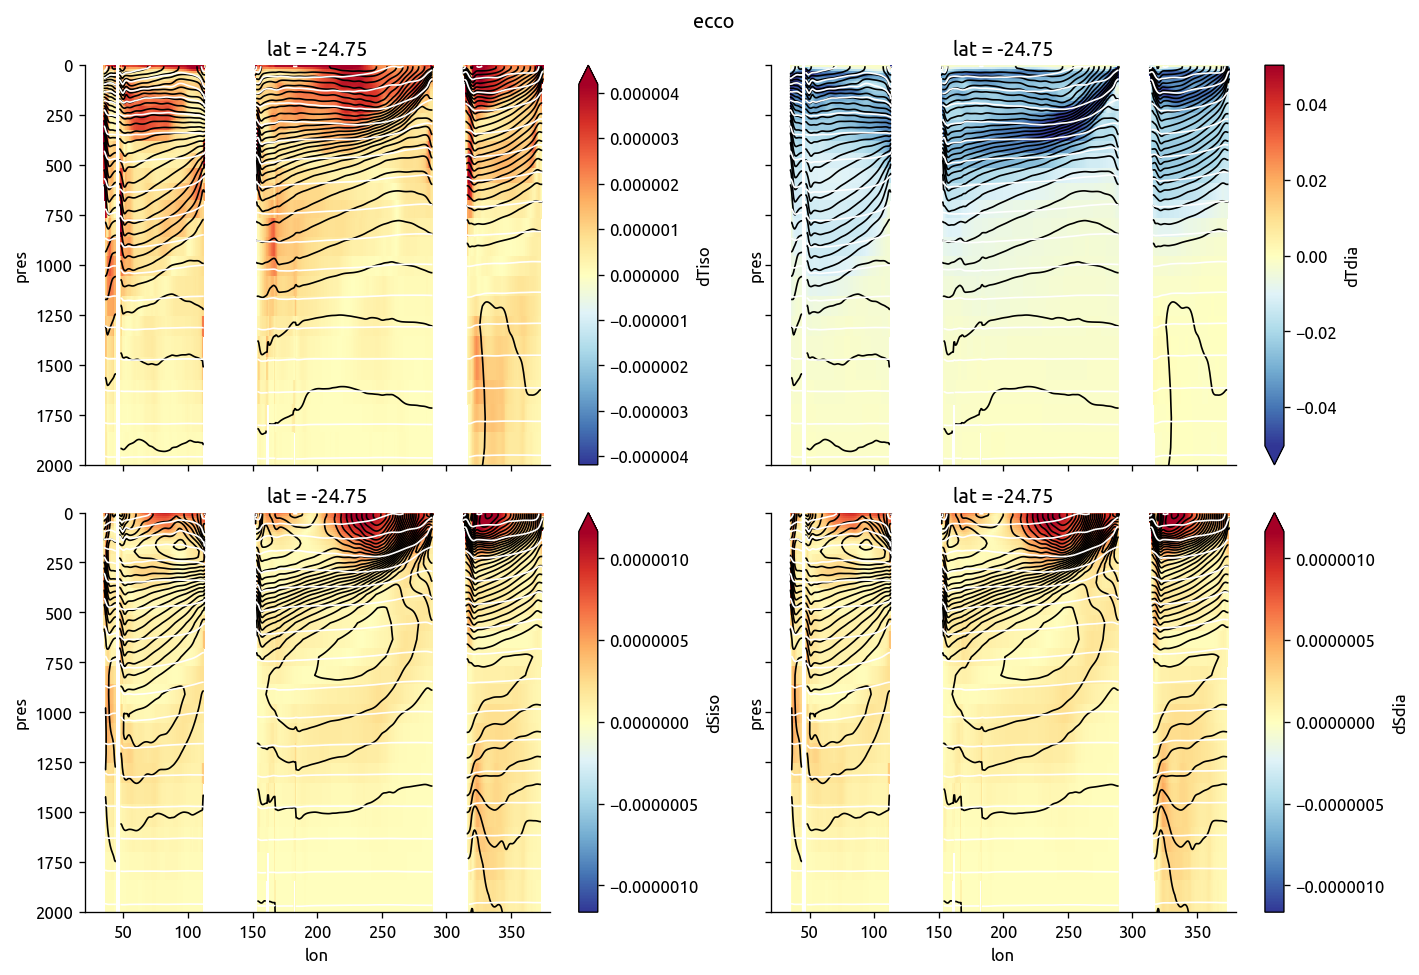

In [53]:
region = dict(lat=-25, method='nearest')
ax = plot_gradients(annual, region)

ax[0,0].set_ylim([2000, 0])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f70effacb38>,
      dtype=object)

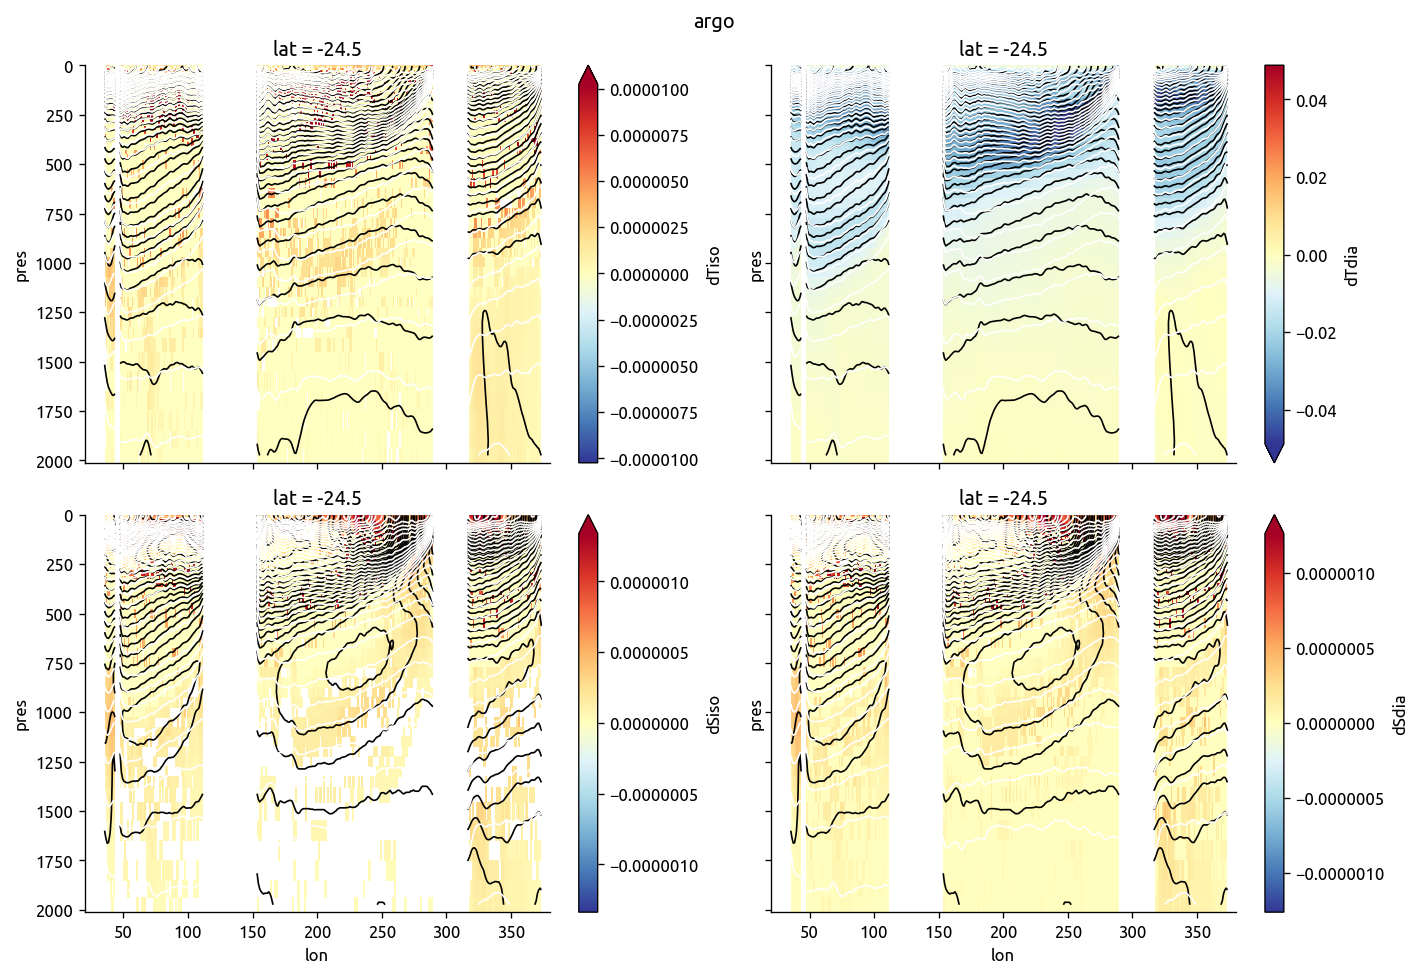

In [54]:
region = dict(lat=-25, method='nearest')
plot_gradients(argo, region)

Looks like the ECCO product (0.5°) is a lot smoother than the Argo 1° product. Maybe the interpolation from the tiles to a regular grid has something to do with it?

In [ ]:
f, ax = plt.subplots(2, 2, sharex=True, sharey=True)

ax = ax.flat

f.set_size_inches(12, 8)

argodT.dx.sel(pres=50, method='nearest').plot(ax=ax[0], robust=True)
eccodT.dx.sel(pres=50, method='nearest').plot(ax=ax[2], robust=True)

argodT.dy.sel(pres=50, method='nearest').plot(ax=ax[1], robust=True)
eccodT.dy.sel(pres=50, method='nearest').plot(ax=ax[3], robust=True)

## Histograms

ECCO cannot represent the really low gradients seen in Argo. But maybe if I average out the Argo fields, I would do better? At current resolution, there is clear mesoscale signal in the fields.

/home/deepak/work/python/xarray/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/home/deepak/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/deepak/work/python/xarray/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/home/deepak/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1.05,'Compare isopycnal |∇S| : ECCO, Argo, 2000db')

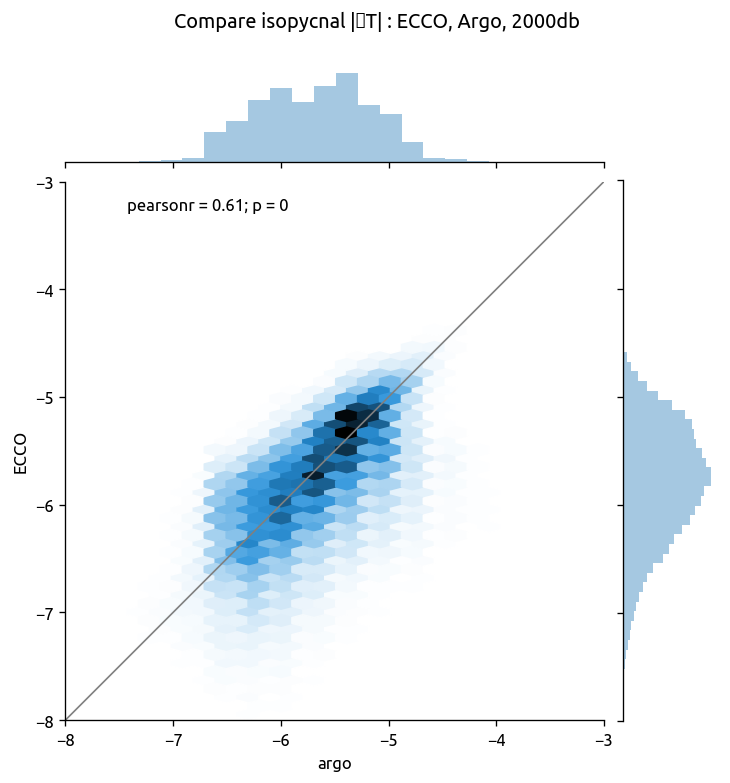

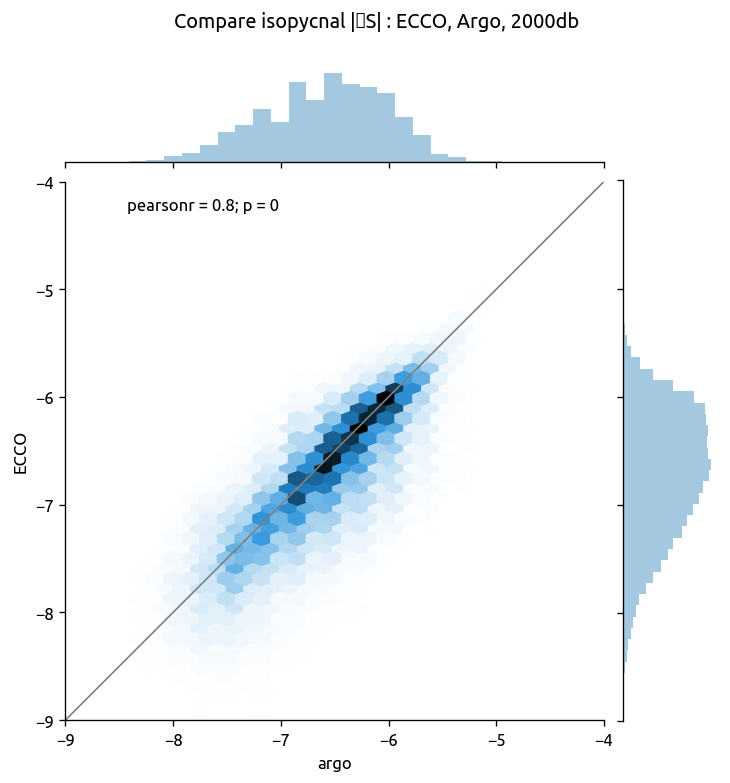

In [42]:
def log(input):
    input.values[input == 0] = np.nan
    return np.log10(input).values


tlim = [-8, -3]
slim = [-9, -4]
g = sns.jointplot(x=log(argo.dTiso),
                  y=log(annual.dTiso.interp(pres=argo.pres, 
                                            lat=argo.lat, 
                                            lon=argo.lon)),
                  kind='hex', xlim=tlim, ylim=tlim)
dcpy.plots.line45(ax=g.ax_joint)
g.ax_joint.set_xlabel('argo')
g.ax_joint.set_ylabel('ECCO')
g.fig.suptitle('Compare isopycnal |∇T| : ECCO, Argo, 2000db', y=1.05)

g = sns.jointplot(x=log(argo.dSiso),
                  y=log(annual.dSiso.interp(pres=argo.pres, 
                                            lat=argo.lat, 
                                            lon=argo.lon)),
                  kind='hex', xlim=slim, ylim=slim)
dcpy.plots.line45(ax=g.ax_joint)
g.set_axis_labels('argo', 'ECCO')
g.fig.suptitle("Compare isopycnal |∇S| : ECCO, Argo, 2000db", y=1.05)

## smooth argo

Smoothing the argo fields doesn't seem to make it look better?

In [ ]:
f, ax = plt.subplots(3,1, sharex=True, sharey=True)
f.set_size_inches(8, 10)
argodS.dy.sel(pres=50, method='nearest').plot(robust=True, ax=ax[0])

smooth = argodS.dy.copy()
smooth.values = sp.ndimage.filters.gaussian_filter(smooth.values, [2,2,0])
smooth.sel(pres=50, method='nearest').plot(robust=True, ax=ax[1])

eccodT.dy.sel(pres=50, method='nearest').plot(ax=ax[2], robust=True)

In [ ]:
(annual.dTiso.interp(pres=argo.pres, lat=argo.lat, lon=argo.lon)
 .sel(lat=-25, method='nearest').plot(robust=True, yincrease=False))

# Idealized gradient test

In [184]:
iso

<xarray.Dataset>
Dimensions:  (lat: 200, lon: 5, pres: 150)
Coordinates:
  * pres     (pres) float64 0.0 1.007 2.013 3.02 4.027 5.034 6.04 7.047 ...
  * lat      (lat) float64 0.0 0.5025 1.005 1.508 2.01 2.513 3.015 3.518 ...
  * lon      (lon) float64 0.0 25.0 50.0 75.0 100.0
Data variables:
    dz       (pres, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    dy       (pres, lat, lon) float64 4.724e-12 4.724e-12 4.724e-12 ...
    dx       (pres, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    mag      (pres, lat, lon) float64 1.423e-17 1.423e-17 1.423e-17 ...

In [168]:
dc.dy

<xarray.DataArray 'dy' (pres: 150, lat: 200, lon: 5)>
array([[[ 4.724245e-12,  4.724245e-12, ...,  4.724245e-12,  4.724245e-12],
        [ 4.937683e-12,  4.937683e-12, ...,  4.937683e-12,  4.937683e-12],
        ...,
        [-5.280895e-14, -5.280895e-14, ..., -5.280895e-14, -5.280895e-14],
        [-4.909130e-14, -4.909130e-14, ..., -4.909130e-14, -4.909130e-14]],

       [[ 6.373746e-12,  6.373746e-12, ...,  6.373746e-12,  6.373746e-12],
        [ 6.661708e-12,  6.661708e-12, ...,  6.661708e-12,  6.661708e-12],
        ...,
        [-7.124755e-14, -7.124755e-14, ..., -7.124755e-14, -7.124755e-14],
        [-6.623186e-14, -6.623186e-14, ..., -6.623186e-14, -6.623186e-14]],

       ...,

       [[ 9.641914e-17,  9.641914e-17, ...,  9.641914e-17,  9.641914e-17],
        [ 1.007753e-16,  1.007753e-16, ...,  1.007753e-16,  1.007753e-16],
        ...,
        [-1.077801e-18, -1.077801e-18, ..., -1.077801e-18, -1.077801e-18],
        [-1.001925e-18, -1.001925e-18, ..., -1.001925e-18, -1.001

In [146]:
dc

<xarray.Dataset>
Dimensions:  (lat: 200, lon: 5, pres: 120)
Coordinates:
  * pres     (pres) float64 -100.0 -99.16 -98.32 -97.48 -96.64 -95.8 -94.96 ...
  * lat      (lat) float64 0.0 0.5025 1.005 1.508 2.01 2.513 3.015 3.518 ...
  * lon      (lon) float64 0.0 25.0 50.0 75.0 100.0
Data variables:
    dz       (pres, lat, lon) float64 -7.223e-05 -7.223e-05 -7.223e-05 ...
    dy       (pres, lat, lon) float64 7.011e-10 7.011e-10 7.011e-10 ...
    dx       (pres, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    mag      (pres, lat, lon) float64 7.223e-05 7.223e-05 7.223e-05 ...